In [10]:
import pandas as pd;
df = pd.read_csv("data/house_data.csv", sep=",", nrows=10000)
df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

### Определение бизнес целей:
1. Прогнозирование цены недвижимости
2. Оценка влияния факторов на цену недвижимости
### Определение целей технического проекта:
1. Построить модель, которая будет прогнозировать стоимость недвижимости на основе данных характеристик.
2. Провести анализ данных для выявления факторов, которые больше всего влияют на цену
### Проверка данных на пропуски

In [11]:
for i in df.columns:
    null_rate = df[i].isnull().sum() / len(df) * 100
    if null_rate > 0:
        print(f'{i} Процент пустых значений: %{null_rate:.2f}')

print(df.isnull().sum())

df.isnull().any()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64


id               False
date             False
price            False
bedrooms         False
bathrooms        False
sqft_living      False
sqft_lot         False
floors           False
waterfront       False
view             False
condition        False
grade            False
sqft_above       False
sqft_basement    False
yr_built         False
yr_renovated     False
zipcode          False
lat              False
long             False
sqft_living15    False
sqft_lot15       False
dtype: bool

Пустых значений нет, номинальных значений тоже.

### Проверка выбросов, и их усреднение

In [12]:
numeric_columns = ['price']
for column in numeric_columns:
    if pd.api.types.is_numeric_dtype(df[column]):  # Проверяем, является ли колонка числовой
        q1 = df[column].quantile(0.25)  # Находим 1-й квартиль (Q1)
        q3 = df[column].quantile(0.75)  # Находим 3-й квартиль (Q3)
        iqr = q3 - q1  # Вычисляем межквартильный размах (IQR)

        # Определяем границы для выбросов
        lower_bound = q1 - 1.5 * iqr  # Нижняя граница
        upper_bound = q3 + 1.5 * iqr  # Верхняя граница

        # Подсчитываем количество выбросов
        outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
        outlier_count = outliers.shape[0]

        # Устраняем выбросы: заменяем значения ниже нижней границы на саму нижнюю границу, а выше верхней — на верхнюю
        df[column] = df[column].apply(lambda x: lower_bound if x < lower_bound else upper_bound if x > upper_bound else x)

        print(f"Колонка {column}:")
        print(f"  Есть выбросы: {'Да' if outlier_count > 0 else 'Нет'}")
        print(f"  Количество выбросов: {outlier_count}")
        print(f"  Минимальное значение: {df[column].min()}")
        print(f"  Максимальное значение: {df[column].max()}")
        print(df.head())

Колонка price:
  Есть выбросы: Да
  Количество выбросов: 499
  Минимальное значение: 75000.0
  Максимальное значение: 1127312.5
           id             date     price  bedrooms  bathrooms  sqft_living  \
0  7129300520  20141013T000000  221900.0         3       1.00         1180   
1  6414100192  20141209T000000  538000.0         3       2.25         2570   
2  5631500400  20150225T000000  180000.0         2       1.00          770   
3  2487200875  20141209T000000  604000.0         4       3.00         1960   
4  1954400510  20150218T000000  510000.0         3       2.00         1680   

   sqft_lot  floors  waterfront  view  ...  grade  sqft_above  sqft_basement  \
0      5650     1.0           0     0  ...      7        1180              0   
1      7242     2.0           0     0  ...      7        2170            400   
2     10000     1.0           0     0  ...      6         770              0   
3      5000     1.0           0     0  ...      7        1050            910   
4  

### Создание выборок
Так как мы будет предсказывать цену, то и целевым признаком будет параметр цены. 

In [13]:
from sklearn.model_selection import train_test_split

#Разделение данных на обучающую и тестовую выборки
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)
#Разделение обучающей выборки на обучающую и контрольную
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=42)

print("Размер обучающей выборки:", len(train_data))
print("Размер контрольной выборки:", len(val_data))
print("Размер тестовой выборки:", len(test_data))

Размер обучающей выборки: 6400
Размер контрольной выборки: 1600
Размер тестовой выборки: 2000


### Визуализвация цен в выборках 

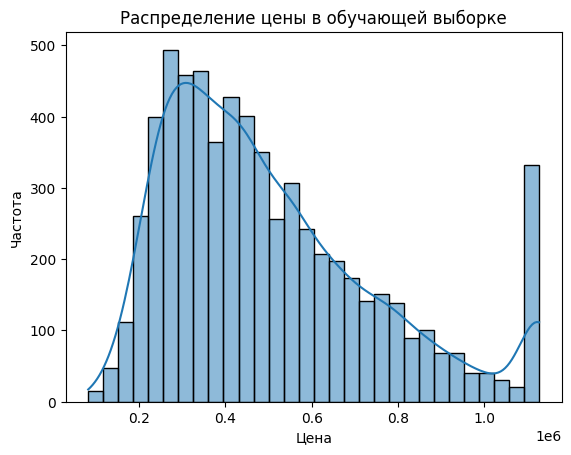

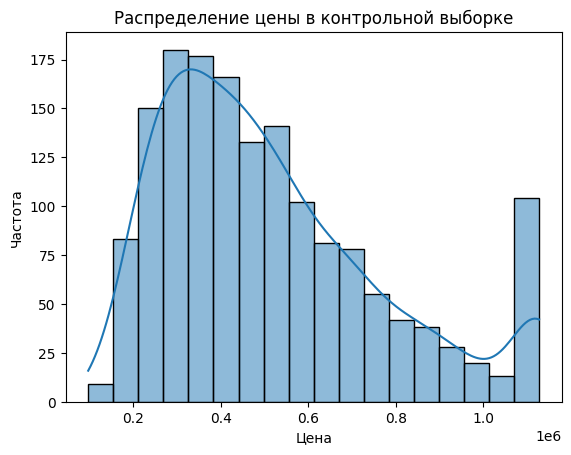

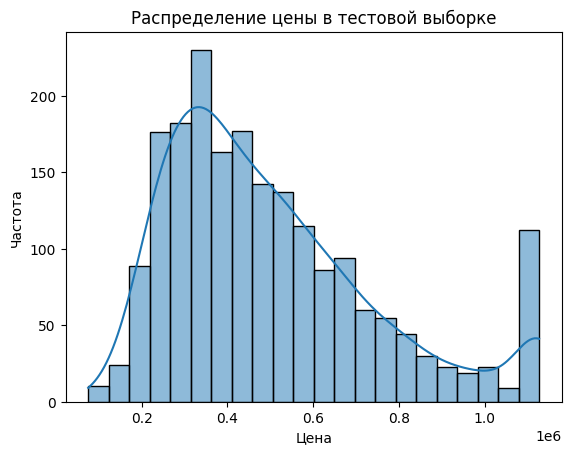

Средняя цена в обучающей выборке:  503651.6890625
Средняя цена в контрольной выборке:  515548.73125
Средняя цена в тестовой выборке:  502023.62175


In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_price_dist(data, title):
    sns.histplot(data['price'], kde=True)
    plt.title(title)
    plt.xlabel('Цена')
    plt.ylabel('Частота')
    plt.show()

plot_price_dist(train_data, 'Распределение цены в обучающей выборке')
plot_price_dist(val_data, 'Распределение цены в контрольной выборке')
plot_price_dist(test_data, 'Распределение цены в тестовой выборке')

print("Средняя цена в обучающей выборке: ", train_data['price'].mean())
print("Средняя цена в контрольной выборке: ", val_data['price'].mean())
print("Средняя цена в тестовой выборке: ", test_data['price'].mean())

### Преобразование целевой переменной в категории дискретизацией

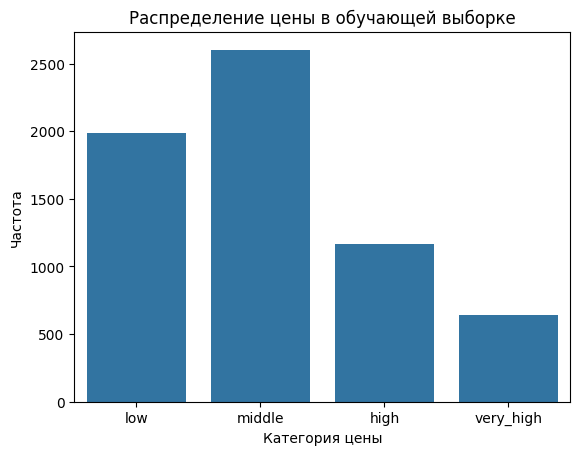

In [15]:
import numpy as np
labels = ["low", "middle", "high", "very_high"]
num_bins = 4
hist1, bins1 = np.histogram(train_data["price"].fillna(train_data["price"].median()), bins=num_bins)
bins1,hist1
pd.concat([train_data["price"], pd.cut(train_data["price"], list(bins1))], axis=1).head(10)
pd.concat([train_data["price"], pd.cut(train_data["price"], list(bins1), labels=labels)], axis=1).head()
train_data['price_category'] = pd.cut(train_data["price"], list(bins1), labels=labels)
test_data['price_category'] = pd.cut(train_data["price"], list(bins1), labels=labels)
val_data['price_category'] = pd.cut(train_data["price"], list(bins1), labels=labels)

sns.countplot(x=train_data['price_category'])
plt.title('Распределение цены в обучающей выборке')
plt.xlabel('Категория цены')
plt.ylabel('Частота')
plt.show()

### Конструирование признаков
1. Прогнозирование цен недвижимости. Цель технического проекта: Разработка модели машинного обучения для точного прогнозирования рыночной стоимости недвижимости.
2. Оценка влияния факторов на цену недвижимости Цель технического проекта: Разработки модели для анализа данных для выявления факторов, которые больше всего влияют на цену

### Конструирование признаков
Унитарное кодирование - замена категориальных признаков бинарными значениями.

In [16]:
categorical_features = ['price_category']


train_data_encoded = pd.get_dummies(train_data, columns=categorical_features)
val_data_encoded = pd.get_dummies(val_data, columns=categorical_features)
test_data_encoded = pd.get_dummies(test_data, columns=categorical_features)

print("Столбцы train_data_encoded:", train_data_encoded.columns.tolist())
print("Столбцы val_data_encoded:", val_data_encoded.columns.tolist())
print("Столбцы test_data_encoded:", test_data_encoded.columns.tolist())

Столбцы train_data_encoded: ['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15', 'price_category_low', 'price_category_middle', 'price_category_high', 'price_category_very_high']
Столбцы val_data_encoded: ['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15', 'price_category_low', 'price_category_middle', 'price_category_high', 'price_category_very_high']
Столбцы test_data_encoded: ['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15',

### Ручной синтез
Создание новых признаков на основе экспертных знаний и логики предметной области.
Новый признак будет - цена недвижимости за фут.

In [17]:
train_data_encoded['price_per_sqft'] = df['price'] / df['sqft_living']
val_data_encoded['price_per_sqft'] = df['price'] / df['sqft_living']
test_data_encoded['price_per_sqft'] = df['price'] / df['sqft_living']
test_data_encoded

id             date     price  bedrooms  bathrooms  sqft_living  \
6252  1150900080  20150427T000000  846450.0         4       2.50         3710   
4684  9268200600  20140519T000000  413500.0         2       1.00          770   
1731  7883603750  20141209T000000  337000.0         3       1.75         1400   
4742  3330501545  20141201T000000  330000.0         2       1.00          950   
4521   993001332  20140903T000000  407000.0         3       2.25         1430   
...          ...              ...       ...       ...        ...          ...   
6412   925069071  20150126T000000  750000.0         5       3.75         3500   
8285  9268200315  20140828T000000  456000.0         3       2.00         1870   
7853  1822300040  20140507T000000  420000.0         2       1.50         1040   
1095  7202290160  20150114T000000  435000.0         3       2.50         1560   
6929  2621700010  20140508T000000  569000.0         4       2.25         2250   

      sqft_lot  floors  waterfront  view  ...  zipcode      lat     long  \
6252      7491     2.0           0     0  ...    98029  47.5596 -122.016   
4684      4000     1.0           0     0  ...    98117  47.6959 -122.364   
1731      6000     1.0           0     0  ...    98108  47.5283 -122.321   
4742      3090     1.0           0     0  ...    98118  47.5510 -122.276   
4521      1448     3.0           0     0  ...    98103  47.6916 -122.341   
...        ...     ...         ...   ...  ...      ...      ...      ...   
6412    101494     1.5           0     0  ...    98053  47.6745 -122.054   
8285      8442     1.5           0     0  ...    98117  47.6964 -122.365   
7853      3500     1.5           0     0  ...    98144  47.5880 -122.304   
1095      3987     2.0           0     0  ...    98053  47.6870 -122.043   
6929     41688     2.0           0     0  ...    98053  47.6695 -122.050   

      sqft_living15  sqft_lot15  price_category_low  price_category_middle  \
6252           3040        7491               False                  False   
4684           1420        5040               False                  False   
1731           1030        6000               False                  False   
4742           1230        4120               False                  False   
4521           1430        1383               False                  False   
...             ...         ...                 ...                    ...   
6412           3250       38636               False                  False   
8285           1640        6174               False                  False   
7853           1340        1213               False                  False   
1095           1600        3152               False                  False   
6929           2350       37920               False                  False   

      price_category_high  price_category_very_high  price_per_sqft  
6252                False                     False      228.153639  
4684                False                     False      537.012987  
1731                False                     False      240.714286  
4742                False                     False      347.368421  
4521                False                     False      284.615385  
...                   ...                       ...             ...  
6412                False                     False      214.285714  
8285                False                     False      243.850267  
7853                False                     False      403.846154  
1095                False                     False      278.846154  
6929                False                     False      252.888889  

[2000 rows x 26 columns]

### Масштабирование признаков
Это процесс изменения диапазона признаков, чтобы равномерно распределить значения. 

In [18]:
from sklearn.preprocessing import StandardScaler
numerical_features = ['bedrooms']

scaler = StandardScaler()
train_data_encoded[numerical_features] = scaler.fit_transform(train_data_encoded[numerical_features])
val_data_encoded[numerical_features] = scaler.transform(val_data_encoded[numerical_features])
test_data_encoded[numerical_features] = scaler.transform(test_data_encoded[numerical_features])

### Конструирование признаков с применением фреймворка Featuretools

In [21]:
import featuretools as ft

# Удаление дубликатов по идентификатору
train_data_encoded = train_data_encoded.drop_duplicates(subset='id', keep='first')

#Создание EntitySet
es = ft.EntitySet(id='house_data')

#Добавление датафрейма в EntitySet
es = es.add_dataframe(dataframe_name='houses', dataframe=train_data_encoded, index='id')

#Генерация признаков
feature_matrix, feature_defs = ft.dfs(entityset=es, target_dataframe_name='houses', max_depth=2)

feature_matrix

d:\Study\AIM-PIbd-31-Yakovlev-M-G\kernel\Lib\site-packages\featuretools\synthesis\deep_feature_synthesis.py:169: UserWarning: Only one dataframe in entityset, changing max_depth to 1 since deeper features cannot be created
  warnings.warn(


price  bedrooms  bathrooms  sqft_living  sqft_lot  floors  \
id                                                                          
1121059105   378500.0 -0.382609       2.50         2860     43821     2.0   
1026069163   630000.0 -0.382609       2.50         2460     38794     2.0   
3751601501   382450.0 -0.382609       2.50         2220     20531     2.0   
4322300340   265000.0  0.706185       1.50         1740     12728     1.0   
7701960130   820000.0 -0.382609       2.50         2980     18935     1.5   
...               ...       ...        ...          ...       ...     ...   
8645500900   279000.0  0.706185       2.00         2200      7700     1.0   
9528104660   905000.0  0.706185       3.50         2980      3000     2.0   
5100402668   495000.0 -0.382609       1.00         1570      5510     1.0   
1338300180  1127312.5  0.706185       2.25         3960      8640     2.0   
7167000020   792500.0  0.706185       2.50         4290    175421     2.0   

            waterfront  view  condition  grade  ...  sqft_lot15  \
id                                              ...               
1121059105           0     0          4      9  ...       65340   
1026069163           0     0          3      9  ...       51400   
3751601501           0     0          3      8  ...       19249   
4322300340           0     0          4      7  ...       11125   
7701960130           0     0          3     11  ...       18225   
...                ...   ...        ...    ...  ...         ...   
8645500900           0     0          3      7  ...        7700   
9528104660           0     0          3      9  ...        4545   
5100402668           0     0          4      7  ...        6380   
1338300180           0     2          3      9  ...        8640   
7167000020           0     0          3     10  ...       63162   

            price_category_low  price_category_middle  price_category_high  \
id                                                                           
1121059105               False                   True                False   
1026069163               False                  False                 True   
3751601501               False                   True                False   
4322300340                True                  False                False   
7701960130               False                  False                 True   
...                        ...                    ...                  ...   
8645500900                True                  False                False   
9528104660               False                  False                False   
5100402668               False                   True                False   
1338300180               False                  False                False   
7167000020               False                  False                 True   

            price_category_very_high  price_per_sqft  DAY(date)  MONTH(date)  \
id                                                                             
1121059105                     False      132.342657          8            7   
1026069163                     False      256.097561         22            4   
3751601501                     False      172.274775         16            7   
4322300340                     False      152.298851         12            1   
7701960130                     False      275.167785         17           10   
...                              ...             ...        ...          ...   
8645500900                     False      126.818182         20            6   
9528104660                      True      303.691275         27            8   
5100402668                     False      315.286624         18            2   
1338300180                      True      284.674874         29            7   
7167000020                     False      184.731935         16            6   

            WEEKDAY(date)  YEAR(date)  
id                                     
112105

### Оценка качества

d:\Study\AIM-PIbd-31-Yakovlev-M-G\kernel\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



Время обучения: 0.29 секунд
Метрики:
MSE: 2205809457.9675403
RMSE: 46966.04579872081
R²: 0.9623494755346685
MAE: 35440.813340503635 



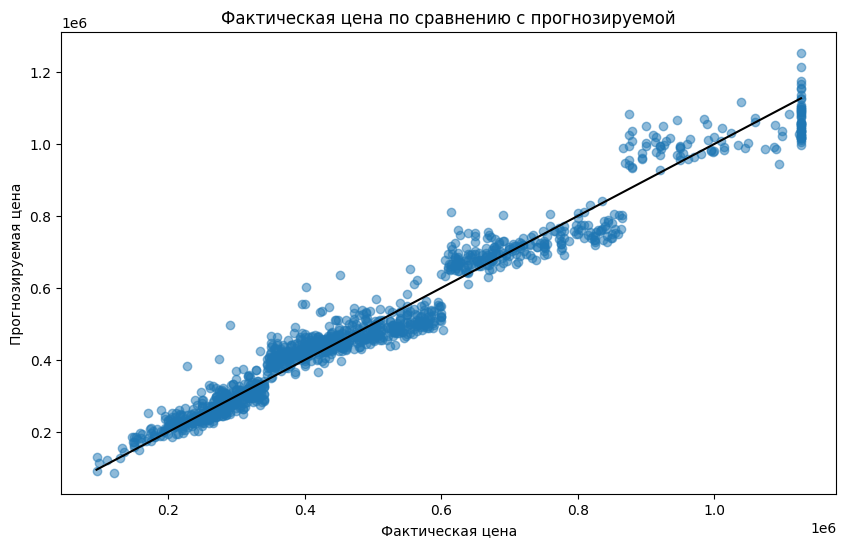

In [39]:
import time
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import cross_val_score

X = feature_matrix.drop('price', axis=1)
y = feature_matrix['price']

#Делим на выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Начнем обучение
model = LinearRegression()
start_time = time.time()
model.fit(X_train, y_train)

train_time = time.time() - start_time

#Вычесляем показательную способность
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print()
print(f"Время обучения: {train_time:.2f} секунд")
print("Метрики:")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"R²: {r2}")
print(f"MAE: {mae} \n")


# Визуализация результатов
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color="black")
plt.xlabel('Фактическая цена')
plt.ylabel('Прогнозируемая цена')
plt.title('Фактическая цена по сравнению с прогнозируемой')
plt.show()
